Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3022754496380928.0000 - val_loss: 3180677222629376.0000
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3229973246640128.0000 - val_loss: 3180674269839360.0000
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3321261165903872.0000 - val_loss: 3180661921808384.0000
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3489729379041280.0000 - val_loss: 3180626219892736.0000
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2961251370008576.0000 - val_loss: 3180541662724096.0000
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3348501995978752.0000 - val_loss: 3180367716548608.0000
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3504217914343424.0000 - val_loss: 3180050157404160.0000
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3102032344907776.0000 - val_loss: 3179511407443968.0000
Epoch 9/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32466

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Топ-10 признаков по важности:
                                Feature  Importance
47                 underground_Аэропорт    0.549311
29                 district_Пресненский    0.510330
91                  underground_Раменки    0.479081
0                          total_meters    0.476427
68   underground_Ломоносовский проспект    0.473050
6                    district_Басманный    0.468621
75              underground_Москва-Сити    0.450491
82               underground_Павелецкая    0.449382
44             underground_Алексеевская    0.446979
103                    underground_Фили    0.435626


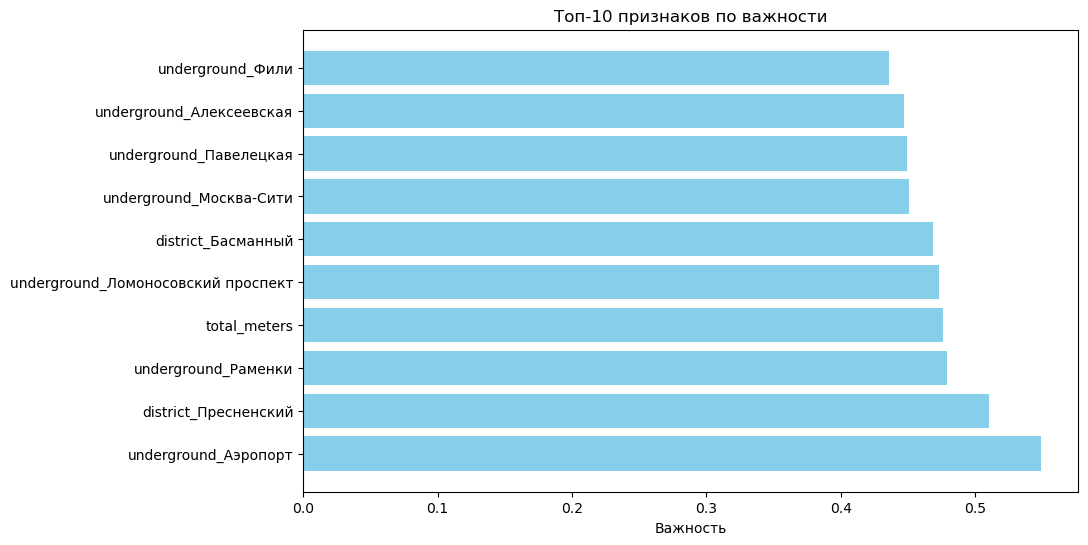

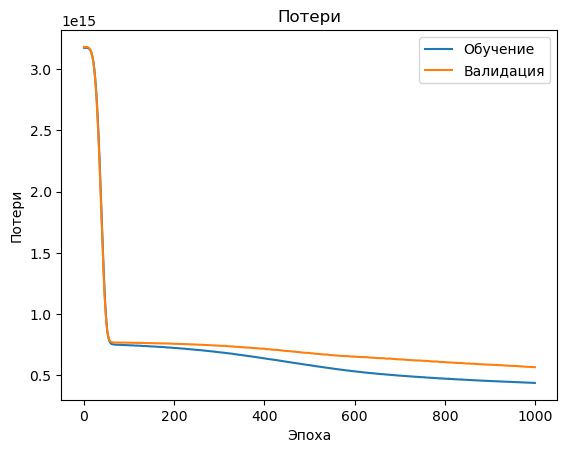

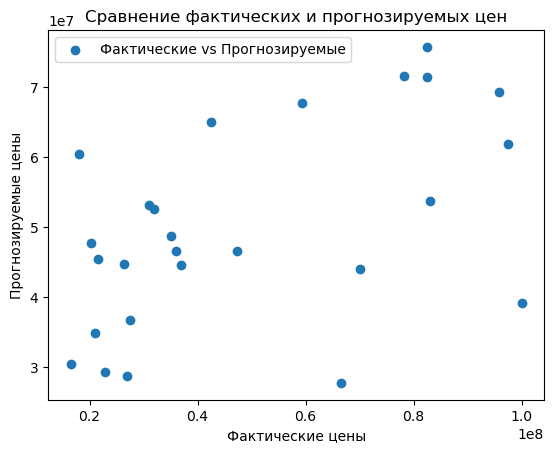

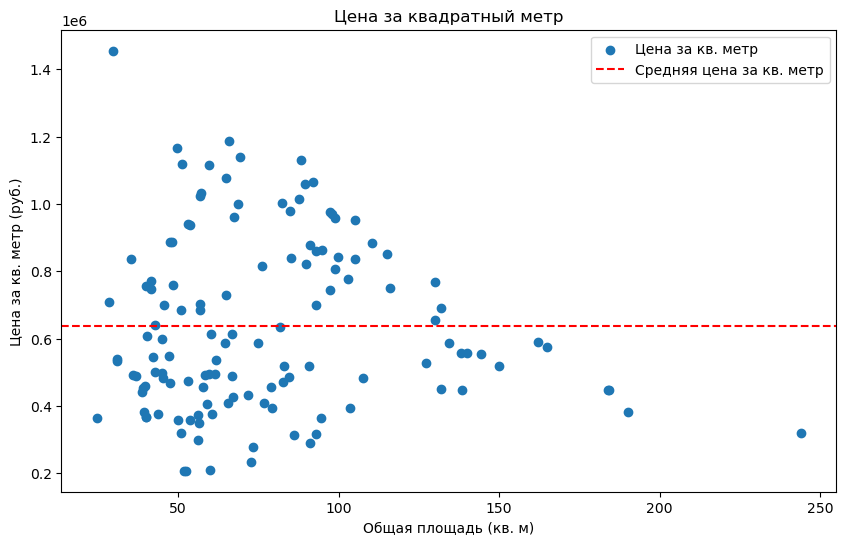

In [49]:
# CNN-модель на основе сверточных нейронных сети (Conv1D)  1000 эпох обучения

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)

# Загрузка данных из последнего файла
data = pd.read_csv(latest_file, sep=',')

# Проверка наличия необходимых колонок
required_columns = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"Отсутствует колонка: {col}")

# Выбор признаков и целевой переменной
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground']
X = data[features]
y = data['price']

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных для использования в CNN
X_train = X_train.toarray().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.toarray().reshape((X_test.shape[0], X_test.shape[1], 1))

# Определение модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели (колич эпох)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=10)

# Оценка модели
loss = model.evaluate(X_test, y_test)
print(f'Потери на тестовых данных: {loss}')

# Прогнозирование цен на тестовых данных
predictions = model.predict(X_test)

# Пример вывода первых 10 прогнозов
for i in range(10):
    print(f'Фактическая цена: {y_test.iloc[i]}, Прогнозируемая цена: {predictions[i][0]}')

# Рассчет средней стоимости 1 кв. метра
data['price_per_sqm'] = data['price'] / data['total_meters']
average_price_per_sqm = data['price_per_sqm'].mean()
print(f'Средняя стоимость 1 кв. метра: {average_price_per_sqm}')

# Создание данных для прогнозирования на три года вперед
future_dates = [datetime.now() + timedelta(days=365 * i) for i in range(1, 4)]
future_features = pd.DataFrame({
    'total_meters': [100, 100, 100],
    'rooms_count': [2, 2, 2],
    'floor': [5, 5, 5],
    'floors_count': [10, 10, 10],
    'district': ['Центральный', 'Центральный', 'Центральный'],
    'underground': ['Китай-город', 'Китай-город', 'Китай-город'],
#    'residential_complex': ['LUMIN', 'LUMIN', 'LUMIN']
})

# Преобразование данных для прогнозирования
future_features_transformed = preprocessor.transform(future_features)

# Преобразование данных для использования в CNN
future_features_transformed = future_features_transformed.toarray().reshape((future_features_transformed.shape[0], future_features_transformed.shape[1], 1))

# Прогнозирование цен на три года вперед
future_predictions = model.predict(future_features_transformed)

# Вывод прогнозов
for i, date in enumerate(future_dates):
    print(f'Дата: {date.strftime("%Y-%m-%d")}, Прогнозируемая цена за кв. метр: {future_predictions[i][0]}')

# Важность признаков
importance_model = Sequential()
importance_model.add(Dense(1, input_shape=(X_train.shape[1],)))
importance_model.compile(optimizer='adam', loss='mean_squared_error')
importance_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train, epochs=50, batch_size=10, verbose=0)

# Получаем важность признаков
feature_importances = np.abs(importance_model.layers[0].get_weights()[0]).flatten()
categorical_feature_names = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names = numerical_features + categorical_feature_names

if len(feature_names) != len(feature_importances):
    raise ValueError("Количество признаков и их важность не совпадает.")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-10 признаков
top_10_importance = importance_df.head(10)
print("Топ-10 признаков по важности:")
print(top_10_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 признаков по важности')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

# График прогнозов
plt.scatter(y_test, predictions, label='Фактические vs Прогнозируемые')
plt.xlabel('Фактические цены')
plt.ylabel('Прогнозируемые цены')
plt.legend()
plt.title('Сравнение фактических и прогнозируемых цен')
plt.show()

# График цены за кв. метр
plt.figure(figsize=(10, 6))
plt.scatter(data['total_meters'], data['price_per_sqm'], label='Цена за кв. метр')
plt.axhline(y=average_price_per_sqm, color='r', linestyle='--', label='Средняя цена за кв. метр')
plt.xlabel('Общая площадь (кв. м)')
plt.ylabel('Цена за кв. метр (руб.)')
plt.title('Цена за квадратный метр')
plt.legend()
plt.show()


In [ ]:
# CNN-модель после улучшения

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)

# Загрузка данных из последнего файла
data = pd.read_csv(latest_file, sep=',')
# Проверка наличия необходимых колонок
required_columns = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"Отсутствует колонка: {col}")

# Выбор признаков и целевой переменной
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground']
X = data[features]
y = data['price']

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных для использования в CNN
X_train = X_train.toarray().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.toarray().reshape((X_test.shape[0], X_test.shape[1], 1))

# Определение модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Dropout для регуляризации
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Еще один Dropout
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2-регуляризация
model.add(Dense(1))

# Компиляция модели с улучшенным оптимизатором Adam и регулировкой learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Обучение модели с уменьшенным размером батча и увеличенным количеством эпох
history = model.fit(X_train, y_train, epochs=1500, validation_data=(X_test, y_test), batch_size=5)

# Оценка модели
loss = model.evaluate(X_test, y_test)
print(f'Потери на тестовых данных: {loss}')

# Прогнозирование цен на тестовых данных
predictions = model.predict(X_test)

# Пример вывода первых 10 прогнозов
for i in range(10):
    print(f'Фактическая цена: {y_test.iloc[i]}, Прогнозируемая цена: {predictions[i][0]}')

# Рассчет средней стоимости 1 кв. метра
data['price_per_sqm'] = data['price'] / data['total_meters']
average_price_per_sqm = data['price_per_sqm'].mean()
print(f'Средняя стоимость 1 кв. метра: {average_price_per_sqm}')

# Прогнозирование на 3 года вперед (обновленные шаги остаются)
...
# Прогнозирование цен на три года вперед
future_predictions = model.predict(future_features_transformed)

# Вывод прогнозов
for i, date in enumerate(future_dates):
    print(f'Дата: {date.strftime("%Y-%m-%d")}, Прогнозируемая цена за кв. метр: {future_predictions[i][0]}')

# Важность признаков
importance_model = Sequential()
importance_model.add(Dense(1, input_shape=(X_train.shape[1],)))
importance_model.compile(optimizer='adam', loss='mean_squared_error')
importance_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train, epochs=50, batch_size=10, verbose=0)

# Получаем важность признаков
feature_importances = np.abs(importance_model.layers[0].get_weights()[0]).flatten()
categorical_feature_names = list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names = numerical_features + categorical_feature_names

if len(feature_names) != len(feature_importances):
    raise ValueError("Количество признаков и их важность не совпадает.")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-10 признаков
top_10_importance = importance_df.head(10)
print("Топ-10 признаков по важности:")
print(top_10_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Топ-10 признаков по важности')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

# График прогнозов
plt.scatter(y_test, predictions, label='Фактические vs Прогнозируемые')
plt.xlabel('Фактические цены')
plt.ylabel('Прогнозируемые цены')
plt.legend()
plt.title('Сравнение фактических и прогнозируемых цен')
plt.show()

# График цены за кв. метр
plt.figure(figsize=(10, 6))
plt.scatter(data['total_meters'], data['price_per_sqm'], label='Цена за кв. метр')
plt.axhline(y=average_price_per_sqm, color='r', linestyle='--', label='Средняя цена за кв. метр')
plt.xlabel('Общая площадь (кв. м)')
plt.ylabel('Цена за кв. метр (руб.)')
plt.title('Цена за квадратный метр')
plt.legend()
plt.show()


Epoch 1/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3447441936351232.0000 - val_loss: 3180675343581184.0000
Epoch 2/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2941788188835840.0000 - val_loss: 3180640983842816.0000
Epoch 3/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3208811674337280.0000 - val_loss: 3180447710314496.0000
Epoch 4/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3171522768273408.0000 - val_loss: 3179799170252800.0000
Epoch 5/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3119033704513536.0000 - val_loss: 3178149634375680.0000
Epoch 6/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3884218903953408.0000 - val_loss: 3174670710865920.0000
Epoch 7/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3157733238898688.0000 - val_loss: 3168339660636160.0000
Epoch 8/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3053254938198016.0000 - val_loss: 3157396083965952.0000
Epoch 9/1500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30909945473